# Benchmark segment anything on validation set

## Segment anything on brain segmentation dataset

To run this notebook, following instruction at https://github.com/facebookresearch/segment-anything to install dependency and backbone model.

Model weights should be placed at `./weights/sam_vit_b_01ec64.pth` for example.

This notebook has following sections:

1. Benchmark Segment Anything model with central prompt

In [1]:
import sys

%load_ext autoreload
%autoreload 2
      
sys.path.append('../')

import torch
from dataset import data_loaders, BrainSegmentationDataset
from utils import postprocess_per_volume, dsc_distribution, plot_dsc, gray2rgb, outline
from skimage.io import imsave, imshow
import numpy as np
from matplotlib import pyplot as plt
import cv2

## Dataloader for validation set only

In [2]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

batch_size = 16
epochs = 50
lr = 0.0001
workers = 2
weights = "./"
image_size = 224
aug_scale = 0.05
aug_angle = 15

_, loader_valid = data_loaders(batch_size, workers, image_size, aug_scale, aug_angle, path="../kaggle_3m", valid_only=True)

reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


## Load Segment Anything Model

In [3]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../weights/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

## Use central point as input

The original size is (224, 224), so central point is (112, 112)

In [4]:
input_point = np.array([[112, 112]])
input_label = np.array([1])

## Evaluate Segment Anything Model on `loader_vaild`

Important shapes:

x: (16, 3, 224, 224), where 3 is channel number

y_true: (16, 1, 224, 224)

16 is default batch size, which can be manipulated by `batch_size` argument in `data_loaders` function.


**Notice that the range of y_true entry is [0, 255]**, where 0 is background (black), 255 is mask (white, groundtruth)

In [5]:
predictor = SamPredictor(sam)

In [6]:
input_list = []
pred_list = []
true_list = []


for i, data in enumerate(loader_valid):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)

    y_true_np = y_true.detach().cpu().numpy()
    true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
    x_np = x.detach().cpu().numpy()
    input_list.extend([x_np[s] for s in range(x_np.shape[0])])

    for j in range(batch_size):
    
        with torch.set_grad_enabled(False):
            im_now = np.transpose(x[j], (1, 2, 0))
            im_now = im_now.detach().cpu().numpy().astype(np.uint8)
            predictor.set_image(im_now)

            # predict masks
            masks_central, score_centrals, logits_central = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=True,
            )
            
            # choose the mask with largest score as prediction
            y_pred = masks_central[0] # (3, 224, 224) ->  (1, 224, 224)
            y_pred = np.expand_dims(y_pred, axis=0)
            y_pred = pred_list.append(y_pred)      
    break


## postprocessing

Choose only largest connect component in prediciton mask

In [7]:
# print(f"{loader_valid.dataset.patient_slice_index = }")
# print(f"{loader_valid.dataset.patients = }")
print(f"{pred_list[0].shape=}")

volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
        loader_valid.dataset.patients,
        use_postprocessing=False
    )

pred_list[0].shape=(1, 224, 224)


## `volumes` explanation

`volumes` is a dictionary with patient name as key

Each entry is a tuple with size 3. The three entries are original image (`x`), predicted mask (`y_pred`) and true mask (`y_true`) respectively.

In [8]:
print(f"{volumes.keys() = }")
print(f"{volumes['TCGA_HT_7616_19940813'][0].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][1].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][2].shape = }")

volumes.keys() = dict_keys(['TCGA_HT_7616_19940813', 'TCGA_CS_6668_20011025', 'TCGA_CS_4944_20010208', 'TCGA_HT_7879_19981009', 'TCGA_DU_7014_19860618', 'TCGA_DU_6408_19860521', 'TCGA_DU_6404_19850629', 'TCGA_DU_5851_19950428', 'TCGA_CS_6667_20011105', 'TCGA_HT_7692_19960724'])
volumes['TCGA_HT_7616_19940813'][0].shape = (16, 3, 224, 224)
volumes['TCGA_HT_7616_19940813'][1].shape = (16, 1, 224, 224)
volumes['TCGA_HT_7616_19940813'][2].shape = (16, 1, 224, 224)


In [9]:
# volumes['TCGA_HT_7616_19940813']


## Plot outputs

The red outline is the prediction and green outline is groundtruth.

**Range of y_true is [0, 255], so we need to use `y_true[s, 0]/255` to draw the outline.**

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

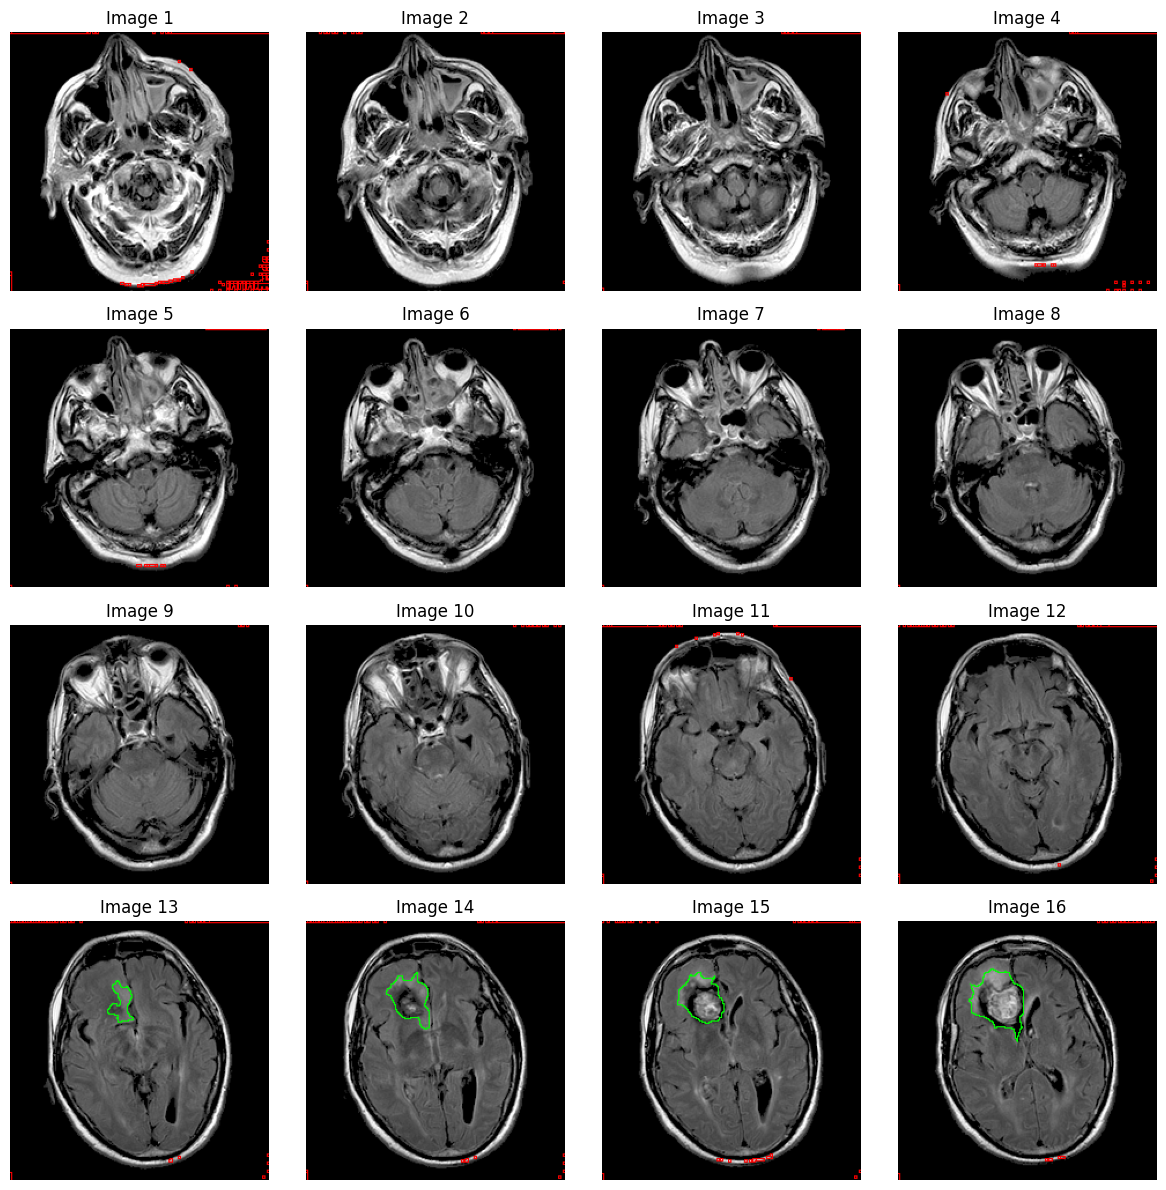

In [11]:
for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    fig, axs = plt.subplots(nrows=int(x.shape[0]/4), ncols=4, figsize=(12, 12))

    for s in range(x.shape[0]):
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0]/255, color=[0, 255, 0])
        # show_mask(y_pred[s, 0], plt.gca())
        axs[int(s/4), s%4].imshow(image)
        axs[int(s/4), s%4].set_title(f"Image {s+1}")
        axs[int(s/4), s%4].axis('off')

    plt.tight_layout()
    plt.show()
    
    break